In [1]:
import sys
sys.path.append('..')
sys.path.append('../policy-gradient-methods/')

In [2]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
from rvi_sampling.distributions.analytic_posterior import TwoStepRandomWalkPosterior
from rvi_sampling.StochasticProcess import RandomWalk, PyTorchWrap
from rvi_sampling import ISSampler, MCSampler, ABCSampler
from rvi_sampling import RVISampler
from rvi_sampling.distributions.proposal_distributions import SimonsProposal
from rvi_sampling.distributions.prior_distributions import DiscreteUniform
from pg_methods.utils.policies import MultinomialPolicy
from pg_methods.utils.networks import MLP_factory
from pg_methods.utils.baselines import MovingAverageBaseline
torch.manual_seed(3)

Populating the interactive namespace from numpy and matplotlib


In [3]:
MC_SAMPLES = 1000
POSSIBLE_STEPS = [[-1], [+1]]
STEP_PROBS = np.ones(2)/2
DIMENSIONS = 1
rw = RandomWalk(DIMENSIONS,
                STEP_PROBS,
                POSSIBLE_STEPS, 
                n_agents=1,
                T=50,
                prior_distribution=DiscreteUniform(DIMENSIONS, -5, 10))
# rw.new_task()
# rw.new_task()
rw.new_task()
print('True Starting Position is:{}'.format(rw.x0))
print('Ending Position is:{}'.format(rw.xT))

True Starting Position is:[1]
Ending Position is:[9]


Text(0.5,1,'Posterior Distribution \n D=[9], E[X0|D]=1.79361')

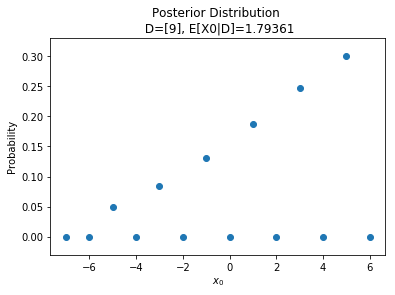

In [4]:
analytic = TwoStepRandomWalkPosterior(5, 0.5, 50)
ax = analytic.plot(rw.xT)
ax.set_title('Posterior Distribution \n D={}, E[X0|D]={:3g}'.format(rw.xT, analytic.expectation(rw.xT)[0]))

1.173913043478261 3.448015122873346


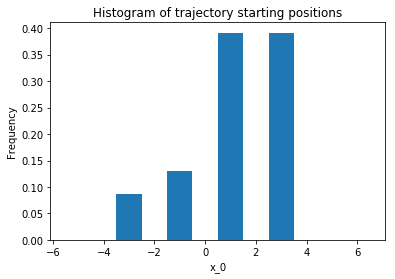

In [5]:
abc = ABCSampler(0)
abc_results = abc.solve(rw, MC_SAMPLES)
print(abc_results.expectation(), abc_results.variance())
abc_results.plot_distribution(5)

../rvi_sampling/StochasticProcess.py:136: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(self.prior.pdf(self.x_agent))


1.8253968253968254 9.883799445704206


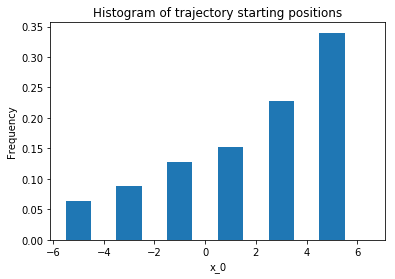

In [6]:
mc = MCSampler()
mc_results = mc.solve(rw, MC_SAMPLES)
print(mc_results.expectation(), mc_results.variance())
mc_results.plot_distribution(5)

../rvi_sampling/StochasticProcess.py:136: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(self.prior.pdf(self.x_agent))
../rvi_sampling/distributions/proposal_distributions.py:89: RuntimeWarning: divide by zero encountered in true_divide
  bias = (sign * self.push_toward - w) * 1. / time_left
../rvi_sampling/distributions/proposal_distributions.py:86: RuntimeWarning: invalid value encountered in true_divide
  sign = w / np.abs(w)


1.1757984434117275 0.5009574192615093


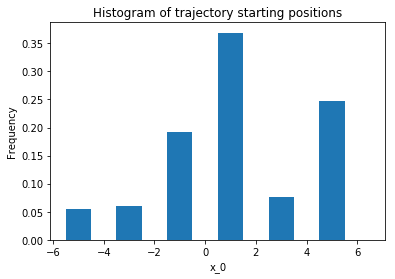

In [7]:
iss = ISSampler(SimonsProposal)
iss_results = iss.solve(rw, MC_SAMPLES)
print(iss_results.expectation(True), iss_results.variance(True))
iss_results.plot_distribution(5)

../rvi_sampling/StochasticProcess.py:136: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(self.prior.pdf(self.x_agent))


1.2944280055253365 0.09360447274428746


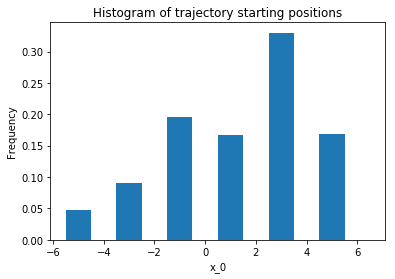

In [8]:
prw = PyTorchWrap(rw)
fn_approximator = MLP_factory(DIMENSIONS+1, hidden_sizes=[32, 32], output_size=2, hidden_non_linearity=nn.ReLU)
policy = MultinomialPolicy(fn_approximator)
policy_optimizer = torch.optim.RMSprop(fn_approximator.parameters(),lr=0.001)

rvi = RVISampler(policy, policy_optimizer, baseline=MovingAverageBaseline(0.99))
rvi_results = rvi.solve(prw, MC_SAMPLES, feed_time=True)
print(rvi_results.expectation(True), rvi_results.variance(True))
rvi_results.plot_distribution(5)

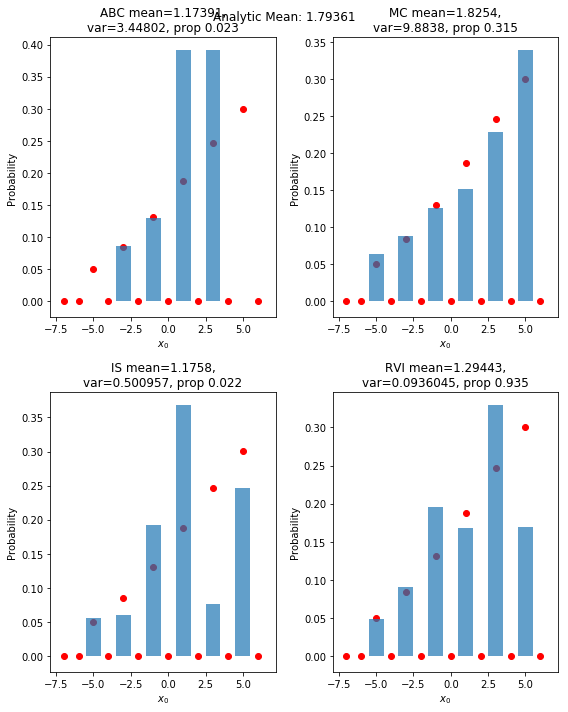

In [9]:
f = plt.figure(figsize=(8, 10))

ax = f.add_subplot(221)
ax = abc_results.plot_distribution(5, ax, alpha=0.7)
ax = analytic.plot(rw.xT, ax, label='analytic', color='r')

ax.set_title("ABC mean={:3g},\nvar={:3g}, prop {}".format(abc_results.expectation(), 
                                                             abc_results.variance(),
                                                             len(abc_results.trajectories())/len(abc_results.all_trajectories())))
ax = f.add_subplot(222)
ax = mc_results.plot_distribution(5, ax, alpha=0.7)
ax = analytic.plot(rw.xT, ax, label='analytic', color='r')

ax.set_title("MC mean={:3g},\nvar={:3g}, prop {}".format(mc_results.expectation(), 
                                                             mc_results.variance(),
                                                             len(mc_results.trajectories())/len(mc_results.all_trajectories())))

ax = f.add_subplot(223)
ax = iss_results.plot_distribution(5, ax, alpha=0.7)
ax = analytic.plot(rw.xT, ax, label='analytic', color='r')

ax.set_title("IS mean={:3g},\nvar={:3g}, prop {}".format(iss_results.expectation(True), 
                                                             iss_results.variance(True),
                                                             len(iss_results.trajectories())/len(iss_results.all_trajectories())))
             
ax = f.add_subplot(224)
ax = rvi_results.plot_distribution(5, ax, alpha=0.7)
ax = analytic.plot(rw.xT, ax, label='analytic', color='r')

ax.set_title("RVI mean={:3g},\nvar={:3g}, prop {}".format(rvi_results.expectation(True), 
                                                             rvi_results.variance(True),
                                                             len(rvi_results.trajectories())/len(iss_results.all_trajectories())))

f.suptitle('Analytic Mean: {:3g}'.format(analytic.expectation(rw.xT)[0]))
f.tight_layout()

# Derivation of Analytic Posterior

Consider that $X_0\sim \text{DiscreteUniform}(-c, c)$. The PMF of this distribution is given by 
$$p_{X_0}(x) = \{\frac{1}{2c} ~~ x \in [-c, c]; 0~~\text{otherwise}\}$$

Let $X_t\sim \text{Bern}(p)$. Since we are taking steps of size +1 or -1, let us define $S_t=2X_t - 1$ the distribution of $P_{S_t}(S_t=s) = P_{S_t}(2X_t-1 = s) = P_{X_t}(X_t = \frac{s+1}{2}) = \{ p ~~\text{if} \frac{s+1}{2}=1 ; 1-p ~~\text{if}\frac{s+1}{2}=0\}$


Possibly more importantly, the total number of steps taken is defined to be $S_T = \sum_{i=1}^T S_t$. What is this distribution?

$$P(S_T=s) = P(\sum_{i=1}^TS_t=s)= P\big(\sum_{i=1}^T(2X_t-1)=s\big) = P\big(\sum_{i=1}^TX_t=\frac{s+T}{2}\big)$$

We know how $\sum_{i=1}^T X_t$ is distributed! It is Bernoulli. Therefore:

$$P(S_T=s)=P\big(\sum_{i=1}^TX_t=\frac{s+T}{2}\big)={T\choose\frac{s+T}{2}}p^{\frac{s+T}{2}}(1-p)^{T-\frac{s+T}{2}} ~\text{if} \frac{s+T}{2}\in [0, T]$$

Let use define the total distance moved as $D=X_0 + S_T$. What is the posterior $P(X_0~|~D)$? Let us employ Bayes Rule:

$$P(X_0~|~D) = \frac{P(D~|~X_0)P(X_0)}{P(D)}$$

For now let us just compute the terms at the top. We already know $P(X_0)$, so let's focus on $P(D~|~X_0)$:

$$P(D=d~|~X_0=x)\propto P(X_0 + S_T = d~|~X_0=x) = P(S_T = d - x~|~X_0=x)$$
$$P(S_T = d - x~|~X_0=x) = P(S_T = d-x)$$

Therefore our posterior is:

$$P_{D|X_0}(d,x) \propto P_{S_T}(d-x)P_{X_0}(x)$$
$$P_{D|X_0}(d,x) \propto \frac{1}{2c}{T\choose\frac{d-x+T}{2}}p^{\frac{d-x+T}{2}}(1-p)^{T-\frac{d-x+T}{2}}~\text{if}~x\in[-c, c]~ \frac{d-x+T}{2}\in [0, T]$$